In [1]:
from __future__ import print_function
import numpy as np

import matplotlib.pyplot as plt

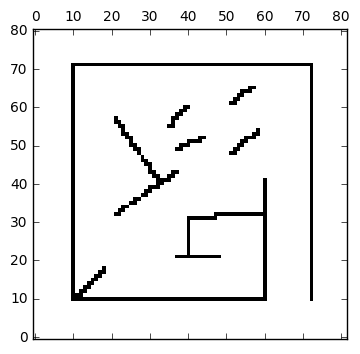

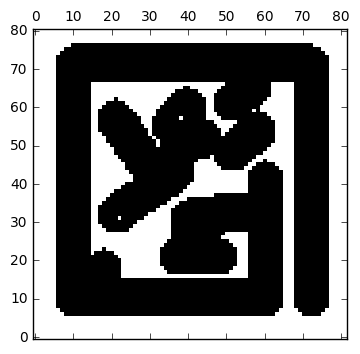

In [2]:
class OccupancyGrid:
    
    def __init__(self, x_min, x_max, y_min, y_max, cell_width, padding):
        """
        Parameters
        ==========
        cell_width : float
            the resolution of the grid map, in meters
        padding : float
            the extra space to add outside the map, in meters
        """
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.padding = padding
        self.cell_width = cell_width
        self.n_width = int((x_max - x_min) / cell_width + 1)
        self.n_height = int((y_max - y_min) / cell_width + 1)
        self._grid = np.zeros((self.n_height, self.n_width))
        
    def occupy_line(self, x1, y1, x2, y2):
        a = np.array([x1, y1])
        v = np.array([x2 - x1, y2 - y1])
        for t in np.linspace(0, 1, self.n_width + self.n_height):
            p = a + t * v
            self.occupy(p[0], p[1])
            
    def expand_obstacles(self, w):
        if w > self.padding:
            raise ValueError('Padding needs to be > expand size atm')
        grid_copy = self._grid + 0
        for degree in np.linspace(0, 2 * np.pi, 40):
            x_displace = int(np.cos(degree) * w / self.cell_width)
            y_displace = int(np.sin(degree) * w / self.cell_width)
            x_shifted = np.roll(grid_copy, x_displace, axis=0)
            shifted = np.roll(x_shifted, y_displace, axis=1)
            self._grid += shifted
                    
        self._grid[self._grid > 0] = 1
        
    def occupy(self, x, y):
        x_ind, y_ind = self.coord_to_inds(x, y)
        self._grid[y_ind, x_ind] = 1.0
    
    def coord_to_inds(self, x, y):
        x_ind = int((x + self.padding + self.cell_width / 2) / self.cell_width)
        y_ind = int((y + self.padding + self.cell_width / 2) / self.cell_width)
        return x_ind, y_ind
    
    def inds_to_coords(self, x, y):
        return (
            x * self.cell_width + self.padding,
            y * self.cell_width + self.padding
        )
    
    def plot(self):
        plt.matshow(-self._grid, origin='lower', cmap='gray')
        plt.show()
        
        
def lines_to_grid(lines, cell_width=0.04, padding=0.4):
    x_max = -np.inf
    x_min = np.inf
    y_max = -np.inf
    y_min = np.inf
    for x1, y1, x2, y2 in lines:
        x_max = max(x1 + padding, x2 + padding, x_max)
        x_min = min(x1 - padding, x2 - padding, x_min)
        y_max = max(y1 + padding, y2 + padding, y_max)
        y_min = min(y1 - padding, y2 - padding, y_min)
    o = OccupancyGrid(x_min, x_max, y_min, y_max, cell_width, padding)
    for x1, y1, x2, y2 in lines:
        o.occupy_line(x1, y1, x2, y2)
    return o
    
with open('src/localization/scripts/map.txt') as f:
    lines = []
    for line in f:
        if line[0] == '#':
            continue
        lines.append(map(float, (line.split())))
    o = lines_to_grid(lines)
    o.plot()
    o.expand_obstacles(0.2)
    o.plot()